# ภาคผนวก A รวมหลักการและวิธีการที่เกี่ยวข้อง

ในภาคผนวกนี้ได้รวบรวมหลักการและวิธีการที่สนับสนุนเนื้อหาหลักของหนังสือ 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

## A.1 ค่าเฉลี่ยที่ให้น้ำหนักแบบเลขชี้กำลัง

ในการปรับปรุงตัวหาค่าเหมาะที่สุดในบทที่ 3 มีการอ้างอิงถึงค่าเฉลี่ยที่ให้น้ำหนักแบบเลขชี้กำลัง 
(exponentially weighted averages) ต่อไปจะใช้ตัวย่อ EWA ซึ่งมีการใช้ในงานสาขาสถิติ
เพื่อช่วยในการลดทอนการแกว่งของข้อมูล คือทำหน้าที่คล้ายตัวกรองความถี่ต่ำในวงจรไฟฟ้า 
บางครั้งจะเรียกชื่อเต็มว่า ค่าเฉลี่ยเคลื่อนที่ให้น้ำหนักแบบเลขชี้กำลัง (exponentially weighted
moving average) เพราะการหาค่าเฉลี่ยจะมีการเคลื่อนที่เป็นหน้าต่างที่มีขนาดเท่ากับจำนวนจุดข้อมูล 
เราจะละคำว่า "เคลื่อนที่" ออกเพื่อความกระชับ

**ตัวอย่าง A.1**

เพื่อความเป็นรูปธรรมในการสาธิตจะใช้ข้อมูลสังเคราะห์ 140 จุด ที่ผสมผสานระหว่างแนวโน้ม (trend) 
กับการรบกวน สร้างเวกเตอร์ $k, y(k)$ ได้โดยฟังก์ชัน gen_data() ดังนี้

In [2]:
def gen_data():
    t_vec = np.arange(-0.7,0.7,0.01)
    t_vec = t_vec[:,np.newaxis]
    numpts = t_vec.shape[0]
    y_vec = 1.5*t_vec**3 - t_vec + 0.7/(3 + 40*t_vec**2) + 0.3*np.random.rand(numpts,1)
    k_vec = np.arange(0,numpts)
    k_vec = k_vec[:,np.newaxis]
    return k_vec, y_vec

In [3]:
k_vec, y_vec = gen_data()

พล็อตข้อมูลดังแสดงในรูปที่ A.1

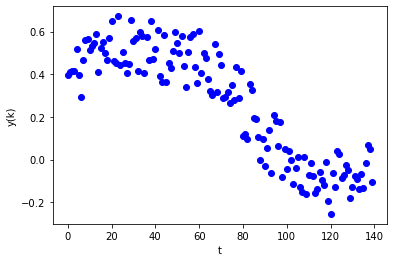

In [5]:
plt.figure()
plt.plot(k_vec,y_vec,'bo')
plt.xlabel("t")
plt.ylabel("y(k)")
plt.show()

รูปที่ A.1 ข้อมูลสังเคราะห์สำหรับการสาธิต EWA

จะเห็นว่าข้อมูลมีการรบกวนค่อนข้างมาก วิธีการ EWA ทำได้โดยกำหนดตัวแปร $v_k, \;\;k = 0,1, \ldots$
ที่เริ่มต้นจากศูนย์ 
$$
v_0 = 0 \tag{A.1}
$$
และค่าที่ตัวชี้ต่อไปเป็นไปตามสมการ
$$
v_k = \beta v_{k-1} + (1-\beta)y_k \tag{A.2}
$$
พิจารณาโดยประมาณได้ว่า $v_k$ คือการเฉลี่ยค่าจำนวน $1/(1-\beta)$ จุดข้อมูล 
ตัวอย่างเช่น $\beta = 0.5,0.9,0.98$ คือการเฉลี่ยค่าทุก 2,10,50 จุดข้อมูลตามลำดับ

จากสมการ (A.1), (A.2) สามารถเขียนเป็นฟังก์ชัน ewa() ได้ดังนี้

In [6]:
def ewa(y, beta):
    v_size = y.shape[0]
    v = np.zeros((v_size,1))
    for k in range(1,v_size):
        v[k,0] = beta*v[k-1,0] + (1-beta)*y[k,0]
    return v       

ทดลองรันฟังก์ชันกับข้อมูลสังเคราะห์ในรูปที่ A.1 โดยใช้ค่า $\beta = 0.5,0.9,0.98$ ได้ผลดังรูปที่ A.2

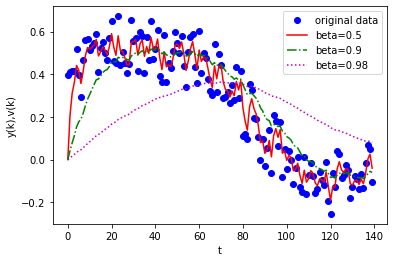

In [27]:
v_1 = ewa(y_vec,0.5)
v_2 = ewa(y_vec,0.9)
v_3 = ewa(y_vec,0.98)
plt.figure()
plt.plot(k_vec,y_vec,'bo',k_vec,v_1,'r-',k_vec,v_2,'g-.',k_vec,v_3,'m:')
plt.xlabel("t")
plt.ylabel("y(k),v(k)")
plt.legend(["original data","beta=0.5","beta=0.9","beta=0.98"])
plt.show()

รูปที่ A.2 ผลจากการรันฟังก์ชัน ewa() โดยใช้ค่า $\beta = 0.5,0.9,0.98$ 

จากผลในรูปที่ A.2 จะเห็นได้ว่าเมื่อเพิ่มค่าของ $\beta$ คือการหาค่าเฉลี่ยโดยใช้หน้าต่างที่มีจำนวนจุดมากขึ้น 
การรบกวนจะลดลง แต่ผลเสียคือกราฟจะเลื่อนมาทางด้านขวาเหมือนมีการหน่วงเวลา 

### A.1.1 การแก้ไขค่าเอนเอียง

หากพิจารณาผลของการใช้ EWA ในรูปที่ A.1 ในช่วงเริ่มต้นของกราพจะเห็นว่ามีค่าน้อยกว่าข้อมูลจริง 
ทั้งนี้เนื่องจากเรากำหนดค่าของ $v_0 = 0$ การแก้ไขค่าเอนเอียง (bias correction) ทำได้โดยหลังจากคำนวณค่า 
$v_k$ ตาม (A.2) ปรับมาตราส่วนค่าของ $v_k$ ดังนี้
$$
\tilde{v}_k = \frac{v_k}{1-\beta^k}  \tag{A.3}
$$
จะเห็นได้ว่าพจน์ของส่วนด้านขวาของ (A.3) คือ $1-\beta^k$ มีค่าน้อยในช่วงเริ่มต้นของขั้นตอนวิธี ช่วยให้ $v_k$ 
ถูกชดเชยให้มีค่ามากขึ้น หลังจาก $k$ มีค่าสูงขึ้น $1-\beta^k$ ลู่เข้าสู่ 1 คือการชดเชยจะน้อยลงตามลำดับ

**หมายเหตุ :** ประเด็นสำคัญที่สามารถทำให้การคำนวณได้ค่าไม่ถูกต้องคือ ต้องใช้ค่าของ $v_k$ ใน (A.2) 
(ที่ยังไม่ได้ถูกชดเชย) เป็น $v_{k-1}$ ในรอบต่อไป 

ในการใช้งานด้านการเรียนรู้ของเครื่อง การแก้ค่าเอนเอียงอาจไม่มีผลมากนักในการปรับปรุงขั้นตอนวิธีหาค่าเหมาะที่สุด 
ยกเว้นการใช้ในบางส่วนของขั้นตอนวิธีที่กล่าวถึงในบทที่ 3

**ตัวอย่าง A.2**

แก้ไขฟังก์ชัน ewa() เป็น ewa_bc() โดยเพิ่มการปรับมาตราส่วน (A.3) ผลของการแก้ค่าเอนเอียงกับข้อมูลเดิมจากตัวอย่าง 
A.1 เป็นดังรูปที่ A.3 

In [24]:
def ewa_bc(y, beta):
    v_size = y.shape[0]
    v = np.zeros((v_size,1))
    v_tmp=0
    for k in range(1,v_size):
        v_tmp = beta*v_tmp + (1-beta)*y[k,0]
        v[k,0] = v_tmp/(1-beta**k)
    return v     

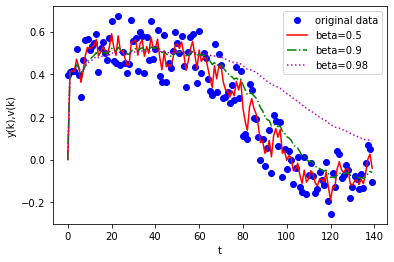

In [26]:
v_1_bc = ewa_bc(y_vec,0.5)
v_2_bc = ewa_bc(y_vec,0.9)
v_3_bc = ewa_bc(y_vec,0.98)
plt.figure()
plt.plot(k_vec,y_vec,'bo',k_vec,v_1_bc,'r-',k_vec,v_2_bc,'g-.',k_vec,v_3_bc,'m:')
plt.xlabel("t")
plt.ylabel("y(k),v(k)")
plt.legend(["original data","beta=0.5","beta=0.9","beta=0.98"])
plt.show()

รูปที่ A.3 ผลจากการรันฟังก์ชัน ewa_bc() ที่มีการแก้ไขค่าเอนเอียง

<p align="center">
<img src="https://drive.google.com/thumbnail?id=13bzT7Rmy3bzvE7TiS0yfQo94kpxMuipF" alt="dewninja"/>
</p>
<div align="center">dew.ninja 2022</div>